<a href="https://colab.research.google.com/github/vishaal-krishnan/vishaal-krishnan.github.io/blob/main/optimal_nav_interacting_particles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Installation and Imports


In [ ]:
pip install jaxlib==0.4.14

In [ ]:
# pip install --upgrade "jax[cuda]"

In [ ]:
pip install --upgrade e3nn-jax

In [ ]:
pip install jax-md

In [ ]:
pip install diffrax

In [ ]:
import jax.numpy as np
from jax.nn import relu
from jax import vmap
from jax import random
from jax_md.quantity import box_size_at_number_density
from jax_md import space
from jax import grad, hessian, jacfwd, jacrev, jvp

from scipy.sparse import csgraph

import time

from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, ControlTerm, Euler, MultiTerm, VirtualBrownianTree, PIDController

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

## Control parameters

In [ ]:
gamma = 1e0
D = 0.0005
beta = 1/(2*gamma*D)

##Initialization of static particles

In [ ]:
key = random.PRNGKey(0)

particle_count = 80
dim = 2

# volume = 8
# number_density = particle_count / volume

box_size = box_size_at_number_density(particle_count = particle_count,
                                      number_density = 1.2,
                                      spatial_dimension = dim)

R_static = random.uniform(key, (particle_count, dim), maxval=0.4, minval=-0.4)

In [ ]:
displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

In [ ]:
static_potential_coeff = random.uniform(key, (particle_count,1), maxval=0.01, minval=-0.01)
# static_potential_coeff = random.uniform(key, (particle_count,1), maxval=-0.01, minval=-0.01)


def potential_static(x):
  dist_x_R = metric(x, R_static)
  d_cutoff = 0.04
  # return np.einsum('ij,ij->', np.exp(-np.square(dist_x_R/0.1))/np.sqrt(np.pi*0.1), static_potential_coeff)
  # return np.einsum('ij,ij->', np.exp(-np.square(dist_x_R/0.2))/np.sqrt(np.pi*0.1) , np.einsum('ij,ij->ij', np.heaviside(0.04-dist_x_R,0), static_potential_coeff))
  return np.einsum('ij,ij->', np.square(dist_x_R)-(d_cutoff)**2 , np.einsum('ij,ij->ij', np.heaviside(d_cutoff-dist_x_R,0), static_potential_coeff))

batch_potential_static = vmap(potential_static)
batch_potential_gradient_static = vmap(jacfwd(potential_static))

In [ ]:
n_grid = 1001
x_coord, y_coord = np.meshgrid(np.linspace(-0.5, 0.5, n_grid), np.linspace(-0.5, 0.5, n_grid))

In [ ]:
grid_points = np.array([x_coord, y_coord])
grid_list = np.reshape(np.transpose(grid_points), (n_grid*n_grid,1,2))
grid_potential = batch_potential_static(grid_list)
grid_potential_gradient = batch_potential_gradient_static(grid_list)

In [ ]:
grid_color = grid_potential
# grid_color = grid_potential

# print(np.max(grid_color))

# plt.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=grid_color, cmap='YlOrRd_r')
## plt.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=np.einsum('ijk,ijk->i', grid_potential_gradient, grid_potential_gradient), cmap='YlOrRd')

# plt.colorbar()

## Dynamic particles

In [ ]:
key = random.PRNGKey(5)

particle_count = 1
dim = 2

# volume = 8
# number_density = particle_count / volume

box_size = box_size_at_number_density(particle_count = particle_count,
                                      number_density = 1.2,
                                      spatial_dimension = dim)

R = random.uniform(key, (particle_count, dim), maxval=0.5, minval=-0.5)

Visualize point cloud

In [ ]:
from jax_md.colab_tools import renderer
renderer.render(box_size, renderer.Disk(R), resolution=(600, 600))

In [ ]:
def adjacency_mat(r,d):
  return np.where((r < d) & (r > 0),
                  1,
                  0.)

displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

dist_matrix = metric(R, R)

A = adjacency_mat(dist_matrix,1.5)
A = np.triu(A,0)

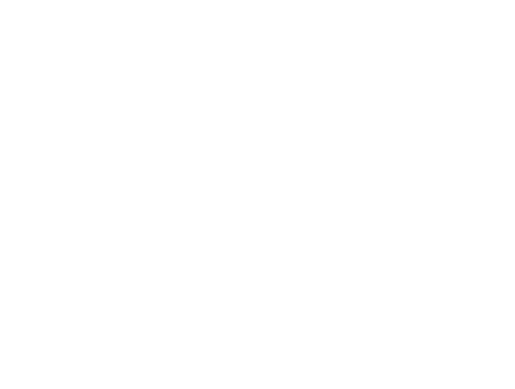

In [ ]:
fig, ax = plt.subplots()

X = np.array([R[np.where(A)[0]],R[np.where(A)[1]]])
ax.plot(X[:,:,0],X[:,:,1], 'ro-', zorder=1)
ax.axis('off')

plt.show()

Parameters

In [ ]:
R0 = R
# R0 = np.zeros(R.shape)
Lambda0 = np.zeros(R.shape)

R_tar = 0.0*np.ones(R0.shape)
# R_tar = 0.5
# R_tar = np.array([4,-10])
# R_tar = R[0]

key = random.PRNGKey(0)

# K = np.multiply(A, random.uniform(key=key, shape=A.shape, minval=0.0, maxval=1.0))
K = 0*1e-4*A
l = 0.01

In [ ]:
def potential_dyn(R,K):
  dr = metric(R, R)
  return 0.5*np.sum(np.multiply(K,np.square(dr - l)))

In [ ]:
def terminal_cost(R):
  dr = metric(R, R)
  # return np.sum(np.square( np.linalg.norm(R,axis=1) - R_tar))
  # return 5e0*np.sum(np.square(np.mean(R, axis=0) - R_tar)) # + 1e2*np.sum(np.multiply(K,np.square(dr - 0.05)))
  return np.sum(np.square(R - R_tar))


batch_terminal_cost = vmap(terminal_cost)

## Feynman-Kac adjoint method

In [ ]:
t0, t1 = 0, 3
dt0 = 0.01
# dt0 was 0.001

n_steps = int((t1-t0)/dt0)
n_samples = 20

In [ ]:
def fwd_uncontrolled_dyn(t, R, args):
  K, i, j = args

  ind = t/dt0
  ind = ind.astype(int)

  # Rdot = - (jacrev(potential_dyn, argnums=0)(R,K) + np.einsum('ijk->jk', jacrev(batch_potential_static)(np.expand_dims(R, axis=1)))) + np.sqrt(2*D/dt0)*random.normal(random.PRNGKey(i*j*ind), shape=np.array(R).shape)
  Rdot = - (jacrev(potential_dyn, argnums=0)(R,K) + np.einsum('ijkl->il', jacrev(batch_potential_static)(np.expand_dims(R, axis=1)))) + np.sqrt(2*D/dt0)*random.normal(random.PRNGKey(i*j*ind), shape=np.array(R).shape)

  return Rdot

In [ ]:
def adj_dyn(t, Lambda, args):
  R, K = args

  ind = (t1-t)/dt0
  ind = ind.astype(int)
  ind = ind - 1

  Lambdadot = np.einsum('ij,ijkl', Lambda, jacfwd(jacrev(potential_dyn, argnums=0), argnums=0)(R[ind], K) + np.einsum('ijklmno->ilmo', jacfwd(jacrev(batch_potential_static))(np.expand_dims(R, axis=2)[ind])) )

  return Lambdadot

In [ ]:
def fwd_uncontrolled_dyn_solver(sample_id):
  return diffeqsolve(ODETerm(fwd_uncontrolled_dyn), Euler(), t0=t_present, t1=t1, dt0=dt0, y0=R, args=[K, int((t_present - t0)/dt0), sample_id], saveat=saveat, max_steps=None)

batch_fwd_uncontrolled_dyn_solver = vmap(fwd_uncontrolled_dyn_solver)

In [ ]:
def adj_dyn_solver(boltzmann_fac, fwd_traj):
  return diffeqsolve(ODETerm(adj_dyn), Euler(), t0=t_present, t1=t1, dt0=dt0, y0=boltzmann_fac*jacfwd(terminal_cost)(fwd_traj[-1,:,:]), args=[fwd_traj, K], saveat=saveat, max_steps=None)

batch_adj_dyn_solver = vmap(adj_dyn_solver)

In [ ]:
key = random.PRNGKey(5)
R = np.array([0.45, 0.45]) + random.uniform(key, (particle_count, dim), maxval=0.025, minval=-0.025)
traj = []
ctrl=[]

In [ ]:
sample_id = random.uniform(random.PRNGKey(0), shape=(n_samples,), minval=0, maxval=100)
sample_id = sample_id.astype(int)

for i in range(int(t1/dt0)):
  traj.append(R)
  print(i, np.sqrt(terminal_cost(R)))
  t_present = t0 + dt0*i
  saveat = SaveAt(ts=np.linspace(t_present,t1,int((t1-t_present)/dt0)))

  fwd_uncontrolled_sol = batch_fwd_uncontrolled_dyn_solver(sample_id)

  terminal_cost_arr = batch_terminal_cost(fwd_uncontrolled_sol.ys[:,-1,:,:])
  boltzmann_fac = n_samples/(1+np.sum(np.exp(-beta*( np.einsum('i,j->ij', terminal_cost_arr, np.ones(terminal_cost_arr.shape[0])) - np.einsum('i,j->ij', np.ones(terminal_cost_arr.shape[0]), terminal_cost_arr) )), axis=0))

  temp = batch_adj_dyn_solver(boltzmann_fac, fwd_uncontrolled_sol.ys).ys[:,-1,:,:]

  Lambda_avg = np.einsum('ijk->jk', temp)/n_samples
  ctrl.append(Lambda_avg)

  R = R + dt0*(-(jacrev(potential_dyn, argnums=0)(R,K) + np.einsum('ijkl->il', jacrev(batch_potential_static)(np.expand_dims(R, axis=1)))) - Lambda_avg) + np.sqrt(2*D*dt0)*random.normal(random.PRNGKey(int(time.time())), shape=np.array(R).shape)


0 0.63542795
1 0.62336403
2 0.61522883
3 0.6060516
4 0.60546863
5 0.59636337
6 0.5920232
7 0.5893601
8 0.58346087
9 0.5785296
10 0.5745111
11 0.5710087
12 0.57067907
13 0.5605427
14 0.556499
15 0.5554868
16 0.5481232
17 0.5409843
18 0.53736347
19 0.5327048
20 0.5264872
21 0.5184718
22 0.51196057
23 0.50233835
24 0.49758455
25 0.49202386
26 0.4871841
27 0.47914627
28 0.4745394
29 0.46777716
30 0.4568558
31 0.44756773
32 0.44075978
33 0.4353885
34 0.43380195
35 0.4237946
36 0.41728222
37 0.4153721
38 0.4144739
39 0.41147828
40 0.4048461
41 0.40201017
42 0.39768544
43 0.39162746
44 0.3886897
45 0.38787425
46 0.38838676
47 0.38489813
48 0.3796142
49 0.378253
50 0.37330034
51 0.36962456
52 0.3668014
53 0.3659835
54 0.35947984
55 0.35900205
56 0.3643728
57 0.36230868
58 0.3627391
59 0.36184403
60 0.36005217
61 0.3636922
62 0.3608816
63 0.3613079
64 0.35476312
65 0.35244015
66 0.3501172
67 0.34439757
68 0.3476633
69 0.3436124
70 0.33695784
71 0.3377102
72 0.33787018
73 0.32951915
74 0.3244066

ValueError: ignored

In [ ]:
# gamma = 1e-5
# beta = 1/(2*gamma*D)

# sample_id = random.uniform(random.PRNGKey(0), shape=(n_samples,), minval=0, maxval=100)
# sample_id = sample_id.astype(int)

# for i in range(200):
#   traj.append(R)
#   print(i, terminal_cost(R))
#   t_present = t0 + dt0*i
#   saveat = SaveAt(ts=np.linspace(t_present,t1,int((t1-t_present)/dt0)))

#   temp = []
#   fwd_uncontrolled_sol = []
#   for n in range(n_samples):
#     step = int((t_present - t0)/dt0)
#     fwd_uncontrolled_sol.append(diffeqsolve(ODETerm(fwd_uncontrolled_dyn), Euler(), t0=t_present, t1=t1, dt0=dt0, y0=R, args=[K, step, sample_id[n]], saveat=saveat, max_steps=None))

#   boltzmann_fac = []
#   for n in range(n_samples):
#     temp_fac = 0.0
#     for m in range(n_samples):
#       if m!=n:
#         temp_fac += np.exp(-beta*(terminal_cost(fwd_uncontrolled_sol[m].ys[-1]) - terminal_cost(fwd_uncontrolled_sol[n].ys[-1])))

#     boltzmann_fac.append(n_samples/(1+temp_fac))

#   for n in range(n_samples):
#     adj_sol = diffeqsolve(ODETerm(adj_dyn), Euler(), t0=t_present, t1=t1, dt0=dt0, y0=boltzmann_fac[n]*jacfwd(terminal_cost)(fwd_uncontrolled_sol[n].ys[-1]), args=[fwd_uncontrolled_sol[n].ys, K], saveat=saveat, max_steps=None)
#     temp.append(adj_sol.ys[-1])

#   Lambda_avg = np.einsum('ijk->jk', temp)/n_samples
#   ctrl.append(Lambda_avg)

#   R = R + dt0*(-(jacrev(potential_dyn, argnums=0)(R,K) + np.einsum('ijk->jk', np.squeeze(jacrev(batch_potential_static, argnums=0)(np.expand_dims(R, axis=1))))) - Lambda_avg) + np.sqrt(2*D*dt0)*random.normal(random.PRNGKey(int(i)), shape=np.array(R).shape)


## Controlled path

In [ ]:
traj_arr = np.array(traj)
ctrl_arr = np.array(ctrl)

In [ ]:
str = '_many_obstacles_many_particles_2'
np.save('traj_arr' + str, traj_arr, allow_pickle=True)
np.save('ctrl_arr' + str, ctrl_arr, allow_pickle=True)

In [ ]:
traj = []
ctrl = []

str = ''
traj_arr_old_1 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_old_1 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj.append(traj_arr_old_1)
ctrl.append(ctrl_arr_old_1)

traj_arr = np.array(traj)
ctrl_arr = np.array(ctrl)
traj_arr = np.squeeze(traj_arr)
ctrl_arr = np.squeeze(ctrl_arr)

In [ ]:
traj_arr = []
ctrl_arr = []

str = '_many_obstacles'
traj_arr_old_1 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_old_1 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_old_1)
ctrl_arr.append(ctrl_arr_old_1)

str = '_many_obstacles_2'
traj_arr_old_2 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_old_2 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_old_2)
ctrl_arr.append(ctrl_arr_old_2)

# str = ''
# traj_arr_old_3 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
# ctrl_arr_old_3 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
# traj_arr.append(traj_arr_old_3)
# ctrl_arr.append(ctrl_arr_old_3)

str_base = '_many_obstacles_many_particles_quad_'

str = str_base + '1_1'
traj_arr_1_1 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_1_1 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_1_1)
ctrl_arr.append(ctrl_arr_1_1)

str = str_base + '1_2'
traj_arr_1_2 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_1_2 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_1_2)
ctrl_arr.append(ctrl_arr_1_2)

str = str_base + '1_1_new'
traj_arr.append(np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True))
ctrl_arr.append(np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True))

str = str_base + '1_2_new'
traj_arr.append(np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True))
ctrl_arr.append(np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True))

str = str_base + '2'
traj_arr_2_1 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_2_1 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_2_1)
ctrl_arr.append(ctrl_arr_2_1)

# str = str_base + '3'
# traj_arr_3 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
# ctrl_arr_3 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
# traj_arr.append(traj_arr_3)
# ctrl_arr.append(ctrl_arr_3)

str = str_base + '3_1'
traj_arr_3_1 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_3_1 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_3_1)
ctrl_arr.append(ctrl_arr_3_1)

str = str_base + '3_2'
traj_arr_3_2 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_3_2 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_3_2)
ctrl_arr.append(ctrl_arr_3_2)

str = str_base + '4'
traj_arr_4_1 = np.load('/content/' + 'traj_arr' + str + '.npy', allow_pickle=True)
ctrl_arr_4_1 = np.load('/content/' + 'ctrl_arr' + str + '.npy', allow_pickle=True)
traj_arr.append(traj_arr_4_1)
ctrl_arr.append(ctrl_arr_4_1)

In [ ]:
font_files = fm.findSystemFonts()
# print(font_files)
for font_file in font_files:
  fm.fontManager.addfont(font_file)

In [ ]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

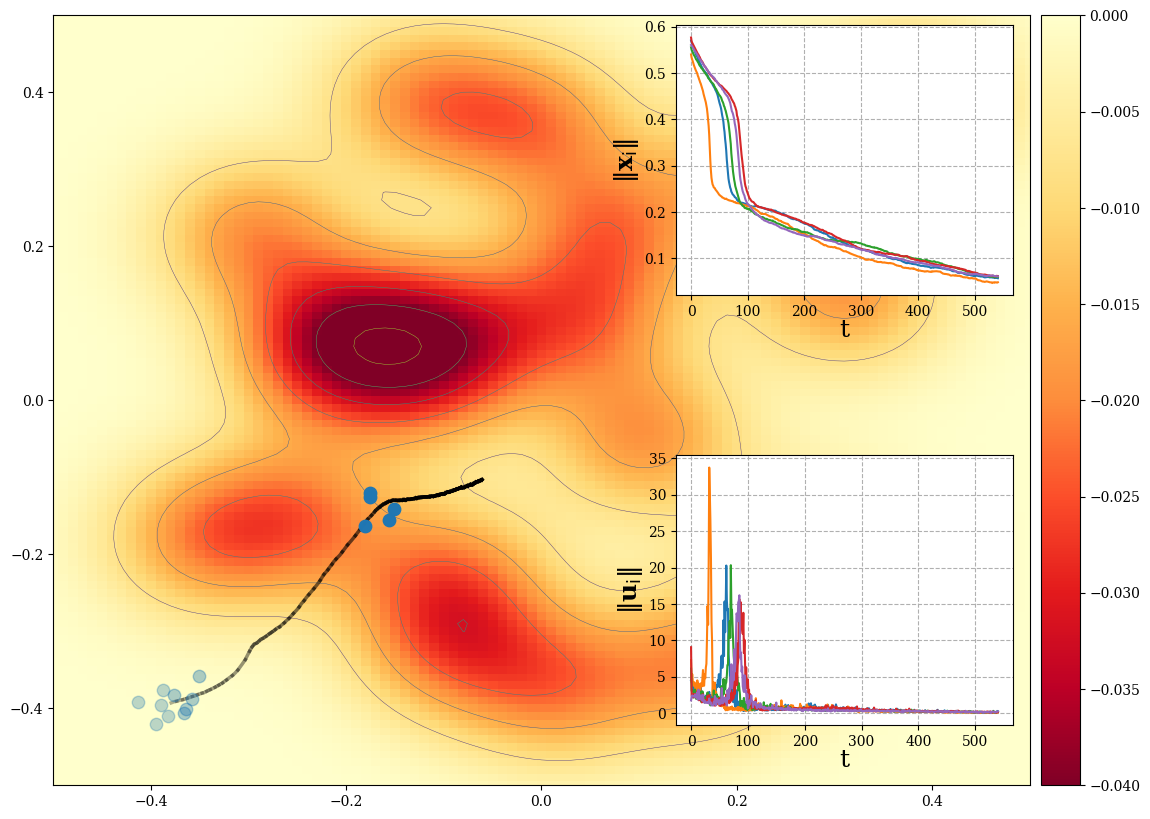

In [ ]:
# fig, ax = plt.subplots(figsize=(15,10))
# # ax.set_aspect('equal')

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# # ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=-grid_color, cmap='YlOrRd')

# for i in range(particle_count):
#     # ax.plot(traj_arr[:,i,0], traj_arr[:,i,1], color=plt.cm.Paired(i))
#     # ax.scatter(traj_arr[0,i,0], traj_arr[0,i,1], marker='+', s=0.5, color=plt.cm.Paired(i))
#     ax.scatter(traj_arr[-1,i,0], traj_arr[-1,i,1], marker='o', s=10, color=plt.cm.Paired(i))

# # window = 2
# # [ ax.plot(np.mean(traj_arr[window*i:window*(i+1)+1,:,0], axis=1), np.mean(traj_arr[window*i:window*(i+1)+1,:,1], axis=1), alpha = min(0.3+0.7*0.01*i, 1.0), color='k', linewidth = 2.5, zorder = i) for i in range(int(t1/(dt0*window))-1) ]

# # ax.plot(np.mean(traj_arr[:,:,0], axis=1), np.mean(traj_arr[:,:,1], axis=1), color='k', linewidth = 2.0)

# K = [0, 10, 99]

# for k in K:
#   X = np.array([traj_arr[k][np.where(A)[0]], traj_arr[k][np.where(A)[1]]])
#   ax.plot(X[:,:,0],X[:,:,1], 'b-', linewidth=1.5, alpha= min(0.3+0.7*0.01*k, 1.0), zorder=int(t1/(dt0*window))+2)
#   ax.scatter(traj_arr[k,:,0], traj_arr[k,:,1], s=80, c=color_cycle[0:particle_count], alpha= min(0.3+0.7*0.01*k, 1.0), zorder=int(t1/(dt0*window))+2)

# ax.set_xlim(-0.5,0.5)
# ax.set_ylim(-0.5,0.5)

# # plt.xlabel(r'$x$', fontsize=18, labelpad=0)
# # plt.ylabel(r'$y$', fontsize=18, labelpad=0)

# heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r', vmin=-0.04, vmax = 0.0)
# contour_plot = ax.contour(y_coord, x_coord, -np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.3, zorder=1)
# fig.colorbar(heat_map, ax=ax, pad=0.01)

# left, bottom, width, height = [0.54, 0.17, 0.9*0.25, 0.9*0.3]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(np.arange(0,ctrl_arr.shape[0],1), np.linalg.norm(ctrl_arr, axis=2), linewidth=1.5)
# ax2.set_xlabel(r't', fontsize=18, labelpad=0)
# ax2.set_ylabel(r'$\|$u$_{\rm i}\|$', fontsize=18, weight='bold', labelpad=2.5)
# ax2.grid(linestyle='--')

# left, bottom, width, height = [0.54, 0.60, 0.9*0.25, 0.9*0.3]
# ax3 = fig.add_axes([left, bottom, width, height])
# ax3.plot(np.arange(0,traj_arr.shape[0],1), np.linalg.norm(traj_arr, axis=2), linewidth=1.5)
# ax3.set_xlabel(r't', fontsize=18, labelpad=0)
# ax3.set_ylabel(r'$\|$x$_{\rm i}\|$', fontsize=18, weight='bold', labelpad=2.5)
# ax3.grid(linestyle='--')

# # ax.colorbar()
# plt.show()

# # fig.savefig('traj' + str + '.pdf', bbox_inches='tight')

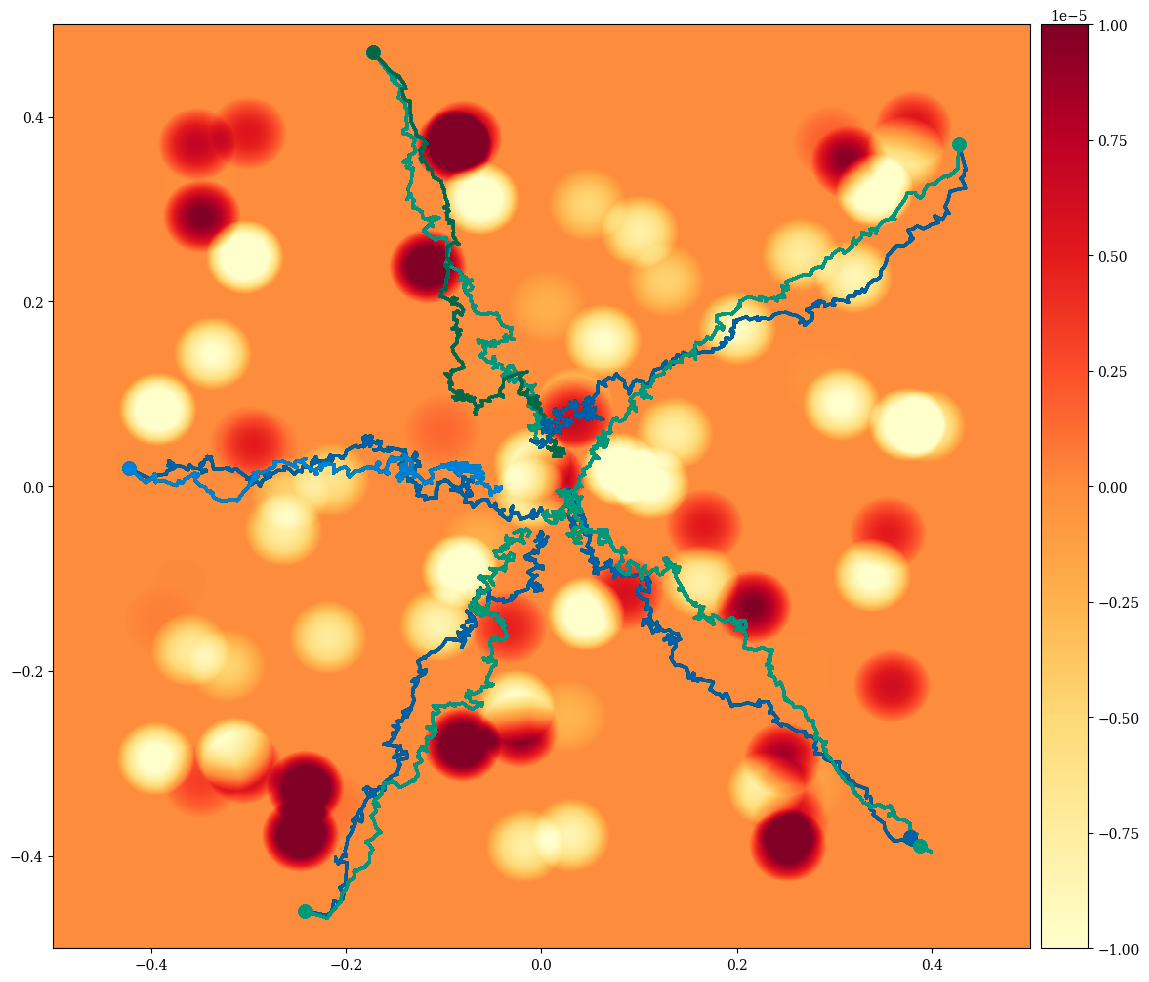

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
# ax.set_aspect('equal')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=grid_color, cmap='YlOrRd')
# ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=np.einsum('ijk,ijk->i', grid_potential_gradient, grid_potential_gradient), cmap='YlOrRd')

quad = [0,0,0,0]

for k in range(len(traj_arr)):
  traj = traj_arr[k]
  ctrl = ctrl_arr[k]

  for i in range(particle_count):
      if traj[0,i,0] >= 0 and traj[0,i,1] >= 0:
        key = random.PRNGKey(quad[0])
        quad[0] += 3
      elif traj[0,i,0] <= 0 and traj[0,i,1] >= 0:
        key = random.PRNGKey(quad[1])
        quad[1] += 3
      elif traj[0,i,0] <= 0 and traj[0,i,1] <= 0:
        key = random.PRNGKey(quad[2])
        quad[2] += 3
      elif traj[0,i,0] >= 0 and traj[0,i,1] <= 0:
        key = random.PRNGKey(quad[3])
        quad[3] += 3

      color_temp = random.uniform(key, (1, 3), maxval=1.0, minval=0.0)
      ax.plot(traj[:,i,0], traj[:,i,1], color=(0.0, float(color_temp[0,1]), float(color_temp[0,2])), linewidth=2.0)
      ax.scatter(traj[0,i,0], traj[0,i,1], marker='o', s=80, color=(0.0, float(color_temp[0,1]), float(color_temp[0,2])), zorder=10)

# ax.plot(np.mean(traj_arr[:,:,0], axis=1), np.mean(traj_arr[:,:,1], axis=1), color='k', linewidth = 2.0)

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)

# plt.xlabel(r'$x$', fontsize=18, labelpad=0)
# plt.ylabel(r'$y$', fontsize=18, labelpad=0)

# plt.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=np.einsum('ijk,ijk->i', grid_potential_gradient, grid_potential_gradient), cmap='YlOrRd')

# heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(np.einsum('ijk,ijk->i', grid_potential_gradient, grid_potential_gradient))), (n_grid, n_grid)), cmap='YlOrRd', vmin=-0.0000001, vmax = 0.0000001)
heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd', vmin=-0.00001, vmax = 0.00001)
# contour_plot = ax.contour(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.5, levels=20, zorder=1)
fig.colorbar(heat_map, ax=ax, pad=0.01)

# left, bottom, width, height = [0.54, 0.17, 0.9*0.25, 0.9*0.3]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(np.arange(0,ctrl_arr.shape[0],1), np.linalg.norm(ctrl_arr, axis=2), linewidth=1.5)
# ax2.set_xlabel(r't', fontsize=18, labelpad=0)
# ax2.set_ylabel(r'$\|$u$_{\rm i}\|$', fontsize=18, weight='bold', labelpad=2.5)
# ax2.grid(linestyle='--')

# left, bottom, width, height = [0.54, 0.60, 0.9*0.25, 0.9*0.3]
# ax3 = fig.add_axes([left, bottom, width, height])
# ax3.plot(np.arange(0,traj_arr.shape[0],1), np.linalg.norm(traj_arr, axis=2), linewidth=1.5)
# ax3.set_xlabel(r't', fontsize=18, labelpad=0)
# ax3.set_ylabel(r'$\|$x$_{\rm i}\|$', fontsize=18, weight='bold', labelpad=2.5)
# ax3.grid(linestyle='--')

# ax.colorbar()
plt.show()

# fig.savefig('traj' + str + '.pdf', bbox_inches='tight')

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection": "3d"})

surf = ax.plot_surface(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd', linewidth=0, antialiased=False)

for i in range(particle_count):
  traj_potential = batch_potential_static(traj_arr)
  ax.plot(traj_arr[:,i,0], traj_arr[:,i,1], traj_potential, linewidth=0.5, color=color_cycle[i], zorder=10)
  # ax.scatter(traj_arr[0,i,0], traj_arr[0,i,1], traj_potential, marker='o', s=80, color=color_cycle[i], zorder=10)

ax.view_init(elev=40.0, azim=-30)
ax.set_zlim(-0.00001, 0.00001)
ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter('{x:.02f}')
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
# fig.savefig('landscape_nav' + str + '.pdf', bbox_inches='tight')

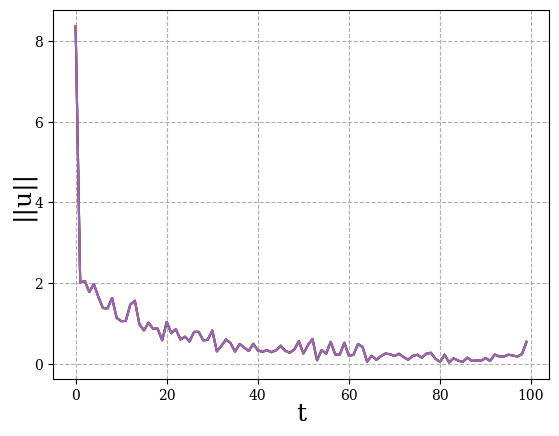

In [ ]:
plt.plot(np.arange(0,ctrl_arr.shape[0],1), np.linalg.norm(ctrl_arr, axis=2))
plt.xlabel(r't', fontsize=18, labelpad=0)
plt.ylabel(r'||u||', fontsize=18, labelpad=0)
plt.grid(linestyle='--')
plt.savefig('ctrl' + str + '.pdf', bbox_inches='tight')

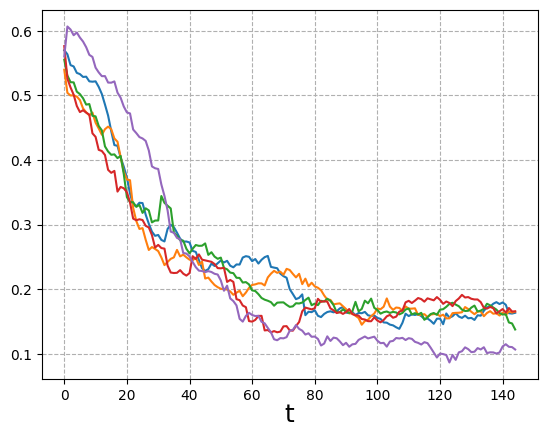

In [ ]:
plt.plot(np.arange(0,traj_arr.shape[0],1), np.linalg.norm(traj_arr, axis=2))
plt.xlabel(r'$\mathrm{t}$', fontsize=18, labelpad=0)
# plt.ylabel(r'$\| \mathrm{r} \|$', fontsize=18, labelpad=-5)
plt.grid(linestyle='--')
plt.savefig('dist' + str + '.pdf', bbox_inches='tight')

Animation

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(j):
    ax.clear()
    #bgrnd = ax.scatter(x_coord, y_coord, c=, s=10, cmap='YlOrRd')
    i=1*j
    bgrnd = ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=-grid_color, cmap='YlOrRd')

    # traj1= ax.plot(traj_arr[0:i,0,0],traj_arr[0:i,0,1],'--g')
    # traj2= ax.plot(traj_arr[0:i,1,0],traj_arr[0:i,1,1],'--y')
    # traj3= ax.plot(traj_arr[0:i,2,0],traj_arr[0:i,2,1],'--m')
    # traj4= ax.plot(traj_arr[0:i,3,0],traj_arr[0:i,3,1],'--r')
    # traj5= ax.plot(traj_arr[0:i,4,0],traj_arr[0:i,4,1],'--c')

    X = np.array([traj_arr[i][np.where(A)[0]], traj_arr[i][np.where(A)[1]]])
    fgrnd1 = ax.plot(X[:,:,0],X[:,:,1], 'ro-', markersize=1, linewidth=0.5)

    traj_mean = ax.plot(np.mean(traj_arr[0:i,:,0], axis=1), np.mean(traj_arr[0:i,:,1], axis=1), linewidth=0.5, color='k')
    lim1= ax.set_xlim(-0.5, 0.5)
    lim2= ax.set_ylim(-0.5, 0.5)

    return bgrnd, fgrnd1, traj_mean

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames= traj_arr.shape[0])
ani.save('landscape_nav_ctrl' + str + '.gif', dpi=300, writer=PillowWriter(fps=10))

In [ ]:
traj_arr_temp = np.squeeze(np.array(traj_arr))
traj_arr_temp = np.transpose(traj_arr_temp, (1,0,2))
traj_arr = traj_arr_temp
print(traj_arr.shape)

(300, 10, 2)


In [ ]:
ctrl_arr_temp = np.squeeze(np.array(ctrl_arr))
ctrl_arr_temp = np.transpose(ctrl_arr_temp, (1,0,2))
ctrl_arr = ctrl_arr_temp
print(ctrl_arr.shape)

(299, 10, 2)


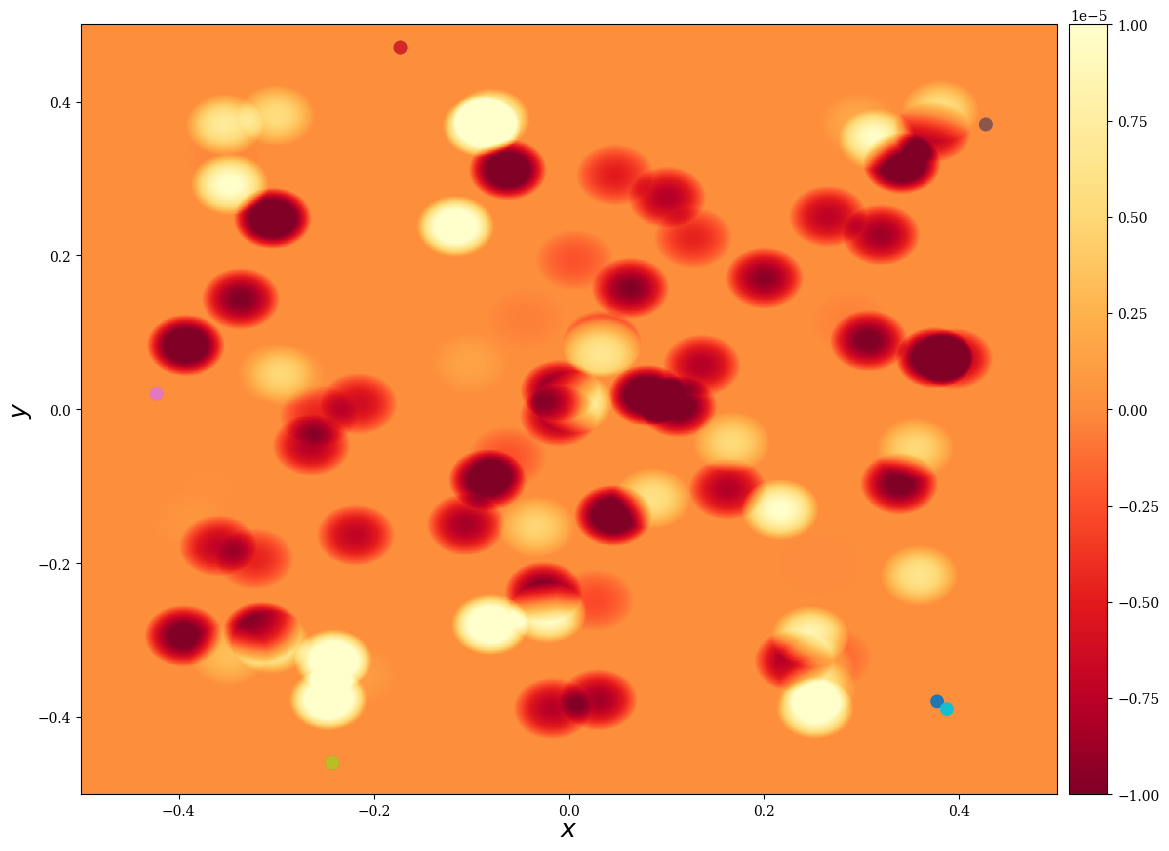

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)

T = 99 #traj_arr.shape[0]

# left, bottom, width, height = [0.54, 0.17, 0.9*0.25, 0.9*0.3]
# ax2 = fig.add_axes([left, bottom, width, height])

# left, bottom, width, height = [0.54, 0.60, 0.9*0.25, 0.9*0.3]
# ax3 = fig.add_axes([left, bottom, width, height])

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r', vmin=-0.00001, vmax = 0.00001)
fig.colorbar(heat_map, ax=ax, pad=0.01)

def animate(i):
    ax.clear()
    # ax2.clear()
    # ax3.clear()

    j = 3*i

    window = 1
    # com = [ ax.plot(np.mean(traj_arr[window*i:window*(i+1)+1,:,0], axis=1), np.mean(traj_arr[window*i:window*(i+1)+1,:,1], axis=1), alpha = min(0.2+0.8*0.01*i, 1.0), color='k', linewidth = 2.5, zorder = i) for i in range(j) ]

    X = np.array([traj_arr[j][np.where(A)[0]], traj_arr[j][np.where(A)[1]]])
    # graph = ax.plot(X[:,:,0],X[:,:,1], 'b-', linewidth=1.5, alpha=1.0, zorder=int(t1/(dt0*window))+2)
    nodes = ax.scatter(traj_arr[j,:,0], traj_arr[j,:,1], s=80, c=color_cycle[0:10], alpha=1.0, zorder=int(t1/(dt0*window))+2)

    traj1= ax.plot(traj_arr[0:j,0,0],traj_arr[0:j,0,1], c=color_cycle[0])
    traj2= ax.plot(traj_arr[0:j,1,0],traj_arr[0:j,1,1], c=color_cycle[1])
    traj3= ax.plot(traj_arr[0:j,2,0],traj_arr[0:j,2,1], c=color_cycle[2])
    traj4= ax.plot(traj_arr[0:j,3,0],traj_arr[0:j,3,1], c=color_cycle[3])
    traj5= ax.plot(traj_arr[0:j,4,0],traj_arr[0:j,4,1], c=color_cycle[4])
    traj6= ax.plot(traj_arr[0:j,5,0],traj_arr[0:j,5,1], c=color_cycle[5])
    traj7= ax.plot(traj_arr[0:j,6,0],traj_arr[0:j,6,1], c=color_cycle[6])
    traj8= ax.plot(traj_arr[0:j,7,0],traj_arr[0:j,7,1], c=color_cycle[7])
    traj9= ax.plot(traj_arr[0:j,8,0],traj_arr[0:j,8,1], c=color_cycle[8])
    traj10= ax.plot(traj_arr[0:j,9,0],traj_arr[0:j,9,1], c=color_cycle[9])

    heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r', vmin=-0.00001, vmax = 0.00001)
    # contour_plot = ax.contour(y_coord, x_coord, -np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.3, zorder=1)

    ax.set_xlabel(r'$x$', fontsize=18, labelpad=0)
    ax.set_ylabel(r'$y$', fontsize=18, weight='bold', labelpad=2.5)

    # if j==0:
    #   c_bar = fig.colorbar(heat_map, ax=ax, pad=0.01)
    # else:
    #   c_bar = []

    # ax2.set_xlabel(r't', fontsize=18, labelpad=0)
    # ax2.set_ylabel(r'$\|$u$_{\rm i}\|$', fontsize=18, weight='bold', labelpad=2.5)
    # ax2.grid(linestyle='--')
    # ax2.set_xlim(0,3*T)
    # ctrl_plot = ax2.plot(np.arange(0,j,1), np.linalg.norm(ctrl_arr[0:j], axis=2), linewidth=1.5)

    # ax3.set_xlabel(r't', fontsize=18, labelpad=0)
    # ax3.set_ylabel(r'$\|$x$_{\rm i}\|$', fontsize=18, weight='bold', labelpad=2.5)
    # ax3.grid(linestyle='--')
    # ax3.set_xlim(0,3*T)
    # traj_plot = ax3.plot(np.arange(0,j,1), np.linalg.norm(traj_arr[0:j], axis=2), linewidth=1.5)

    # return com, graph, nodes, heat_map, contour_plot, ctrl_plot, traj_plot
    return nodes, heat_map, traj1, traj2, traj3, traj4, traj5, traj6, traj7, traj8, traj9, traj10

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=T)
ani.save('landscape_nav_ctrl' + str + '.gif', dpi=300, writer=PillowWriter(fps=10))


## Uncontrolled path

Generate path

In [ ]:
saveat_unc = SaveAt(ts=np.linspace(0,t1,1000))
R0 = np.array([-0.3, -0.3]) + random.uniform(key, (particle_count, dim), maxval=0.025, minval=-0.025)
uncontrolled_path = diffeqsolve(ODETerm(fwd_uncontrolled_dyn), Euler(), t0=t0, t1=t1, dt0=dt0, y0=R0, args=[K, 1, 2], saveat=saveat_unc, max_steps=None)

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

traj_arr = uncontrolled_path.ys

# save as gif
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)

T = 99 #traj_arr.shape[0]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r', vmin=-0.04, vmax = 0.0)
fig.colorbar(heat_map, ax=ax, pad=0.01)

def animate(i):
    ax.clear()

    j = 10*i

    window = 1
    # com = [ ax.plot(np.mean(traj_arr[window*i:window*(i+1)+1,:,0], axis=1), np.mean(traj_arr[window*i:window*(i+1)+1,:,1], axis=1), alpha = min(0.2+0.8*0.01*i, 1.0), color='k', linewidth = 2.5, zorder = i) for i in range(j) ]

    X = np.array([traj_arr[j][np.where(A)[0]], traj_arr[j][np.where(A)[1]]])
    graph = ax.plot(X[:,:,0],X[:,:,1], 'b-', linewidth=1.5, alpha=1.0, zorder=int(t1/(dt0*window))+2)
    nodes = ax.scatter(traj_arr[j,:,0], traj_arr[j,:,1], s=80, c=color_cycle[0:particle_count], alpha=1.0, zorder=int(t1/(dt0*window))+2)

    heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r', vmin=-0.04, vmax = 0.0)
    contour_plot = ax.contour(y_coord, x_coord, -np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.3, zorder=1)

    ax.set_xlabel(r'$x$', fontsize=18, labelpad=0)
    ax.set_ylabel(r'$y$', fontsize=18, weight='bold', labelpad=2.5)

    return graph, nodes, heat_map, contour_plot

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=T)
ani.save('landscape_nav_unc.gif', dpi=300, writer=PillowWriter(fps=10))


Animate

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

sol = uncontrolled_path

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(j):
    ax.clear()
    i=10*j

    bgrnd = ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=-grid_color, cmap='YlOrRd')

    X = np.array([sol.ys[i][np.where(A)[0]],sol.ys[i][np.where(A)[1]]])
    fgrnd1 = ax.plot(X[:,:,0],X[:,:,1], 'ro-', markersize=1, linewidth=0.5)

    traj_mean = ax.plot(np.mean(sol.ys[0:i,:,0], axis=1), np.mean(sol.ys[0:i,:,1], axis=1), linewidth=0.5, color='k')

    lim1= ax.set_xlim(-0.5, 0.5)
    lim2= ax.set_ylim(-0.5, 0.5)

    return bgrnd, fgrnd1, traj_mean

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=100)
ani.save("landscape_nav_unc.gif", dpi=300, writer=PillowWriter(fps=10))